### Create HWMId function supported by Niclas Rieger (via GitHub)

In [120]:
from hwmid import Md
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from itertools import groupby
import multiprocessing as mp
import cartopy.crs as ccrs
from functools import reduce
from itertools import repeat
import warnings
import time
import matplotlib.rasterize_and_save as raster


### Define function

In [125]:
def HWMId_JK (ds_full, grid_len, win = 31, q = 0.9, n_days =3, ref_period=['1979', '2010']):
    """
    Calculate the Heat wave magnitude index daily as defined by Russo et al. (2015)
    The index is derived using the following steps:
        1. Select the grid point
        2. Compute 366 day array with 0.9 quantiles defined with subsets using the values of the reference period in a 31-day window with the day centered on the window. These thresholds take care of the seasonality.
        3. Check whether the daily Tmax are above the daily 0.9 quantile thresholds
        4. Find the indices where there are at least 3 consecutive hot days -> Set heat waves shorter than 3 days to 0 
        5. Calculate the 0.25 quantile of annual maximum T_max in order to select hot temperatures 
        6. Return the daily magnitudes 'Md' using the formula defined by Russo et al. (2015) for hot days only (above 0.25 quantile of annual Tmaxs)
        7. Return the HWMId by calculating the cumulative of consecutive days with a daily magnitude
    """
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', r'All-NaN slice encountered')
        ### 1. Select the grid point
        grid_points = [(lon, lat) for lat in ds_full.lat for lon in ds_full.lon] # Define tuples (lon, lat) with the length of lon*lat
        ds = ds_full.sel(lon=slice(grid_points[grid_len][0].lon, grid_points[grid_len][0].lon), lat=slice(grid_points[grid_len][1].lat, grid_points[grid_len][1].lat)).squeeze() # Select the grid-point data
        #ds=ds_full
        ### 2. Compute 366 day vector with 0.9 quantiles defined with subsets using the values of the reference period in a 31-day window with the day centered on the window. These thresholds take care of the seasonality. 
        plusminus = win // 2
        da_thresh_quantile= []
        for day in range(1,367):
            valid_days = (np.arange(day - plusminus - 1, day + plusminus) % 366) + 1
            window =  ds.sel(time=slice(ref_period[0]+'-01-01', ref_period[1]+'-12-31' )).time.dt.dayofyear.isin(valid_days)
            ds_win =  ds.where(window, drop=True)
            da_thresh_quantile.append(ds_win.quantile(q, dim='time', skipna=False))
        da_thresh_quantile_xr = xr.DataArray(data=xr.concat(da_thresh_quantile, dim='quantile'), dims=['dayofyear'], coords=dict(dayofyear=range(1,367)))

        ### 3. Check whether the daily Tmax are above the daily 0.9 quantile thresholds
        ds = ds.assign_coords(dayofyear=ds.time.dt.dayofyear) # Add the day-of-year coordinate to the dataset
        is_hot_bool = ds.groupby('time.dayofyear') > da_thresh_quantile_xr 

        ### 4. Find the indices where there are at least 3 consecutive hot days -> Set heat waves shorter than 3 days to 0
        convolution = np.convolve(is_hot_bool, np.ones(n_days, dtype=float), mode='valid') >= n_days
        indices = np.flatnonzero(convolution)
        indices = [indices + i for i in range(n_days)]
        idx_heatwave = reduce(np.union1d, (indices))
        idx_all = np.arange(len(is_hot_bool))
        heatw = np.where(np.isin(idx_all, idx_heatwave), is_hot_bool, 0)
        Td = ds.where(heatw !=0)

        ### 5. Calculate the 0.25 quantile of annual maximum T_max in order to select hot temperatures 
        T_ann_max = ds.sel(time=slice(ref_period[0]+'-01-01', ref_period[1]+'-12-31' )).groupby('time.year').max()
        T_ann_max_q25 = T_ann_max.quantile(0.25, dim='year')
        T_ann_max_q75 =  T_ann_max.quantile(0.75, dim='year')

        ### 6. Return the daily magnitudes 'Md' using the formula defined by Russo et al. (2015) for hot days only (above 0.25 quantile of annual Tmaxs)
        Md = (Td - T_ann_max_q25)/ (T_ann_max_q75 - T_ann_max_q25)
        Md_hot = Md.where(Td > T_ann_max_q25)

        ### 7. Calculate HWMId by a cumulative sum over consecutive values and choose maximum value of each year
        Md_hot_filled = Md_hot.fillna(0)
        eps = 1e-5  # to represent zero
        hw_mds = Md_hot_filled.groupby((Md_hot_filled < eps).cumsum('time')).apply(lambda x: x.cumsum(dim='time'))
        HWMId = hw_mds.groupby('time.year').max()


        return Md_hot, HWMId

In [4]:
################# Produce function that converts from 0-360 to -180 and +180
def wrapTo180(ds,longitude):

    # Adjust lon values to make sure they are within (-180, 180)
    ds['_longitude_wrapped'] = xr.where(longitude > 180., longitude - 360., longitude)

    # reassign the new coords to as the main lon coords
    # and sort DataArray using new coordinate values
    ds = (ds.swap_dims({'lon': '_longitude_wrapped'})
          .sel(**{'_longitude_wrapped': sorted(ds._longitude_wrapped)}).drop('lon'))
    ds = ds.rename({'_longitude_wrapped': 'lon'})
    return ds
##################

## Load Maximum Temperature and show European example 

In [5]:
# Load data set with 1 degree resolution
ERA5_t2m_ds = xr.open_dataset('/data/user/jukrueger/Reanalysis/ERA5/ERA5__tmax__1979-2022_daymean_1_deg.nc')
lsm = xr.open_dataset('/data/user/jukrueger/Reanalysis/ERA5/ERA5_lsm_1_deg.nc')
# Calc example 
ERA5_ds_example = ERA5_t2m_ds.mx2t.sel(time=slice('2018-08-01','2018-08-01')).squeeze() - 273.15
ERA5_ds_example_lsm = ERA5_ds_example.where(lsm.lsm!=0).squeeze()

## Show Map of European T2m and of European T2m with lsm

/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


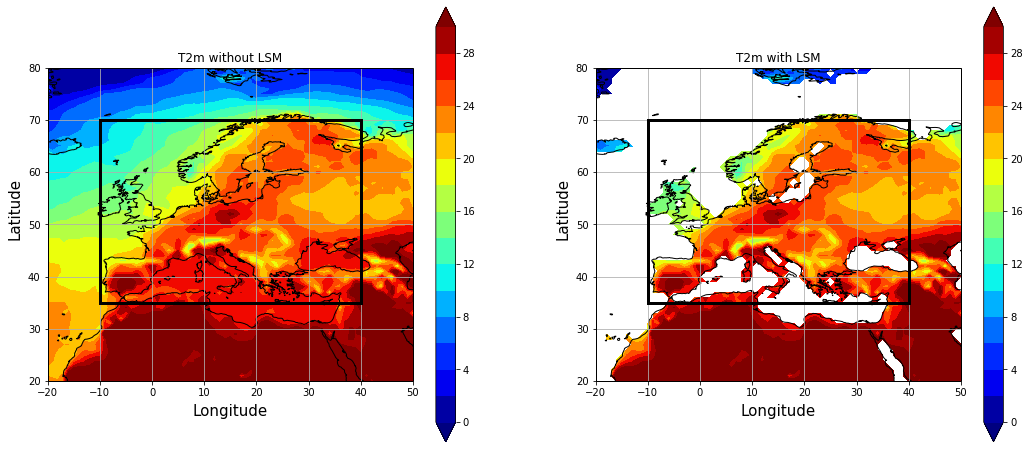

In [77]:
# Define projection and 2x2 subplots
prj = ccrs.PlateCarree()
# Calc X and Y with extended longitude vector
X, Y = (np.meshgrid(np.linspace(0,360,361), ERA5_t2m_ds['lat']))
fig = plt.figure(figsize=(18,8))
axs = []
for i in range(1,3):
    axs.append(fig.add_subplot(1,2,i,projection=prj))
# Define contourIntervals as well as values and properties for the boxes
levels=np.linspace(0,40)
# Show SST boxes
x1, y1 = [-10, 40], [35, 35]
x2, y2 = [-10, 40], [70, 70]
x3, y3 = [-10, -10], [35, 70]
x4, y4 = [40, 40], [35, 70]

color = ['black']
levels=np.linspace(0,30,16)
title = ['T2m without LSM', 'T2m with LSM']
data= [ERA5_ds_example.sel(expver=1).combine_first(ERA5_ds_example.sel(expver=5)), ERA5_ds_example_lsm.sel(expver=1).combine_first(ERA5_ds_example_lsm.sel(expver=5))]
# Plot climatologies with and without mask
for i in range(0,2):    
    cont = axs[i].contourf(X,Y,np.c_[data[i], data[i][:,0]],cmap='jet', transform =prj, levels=levels, extend='both')
    axs[i].plot(x1, y1, x2, y2,x3,y3,x4,y4, color='black', linestyle='-', linewidth=3)
    axs[i].set_title(title[i])

for ax in axs:
    ax.coastlines('50m')
    ax.set_xticks([-20, -10, 0, 10, 20, 30, 40, 50], crs=ccrs.PlateCarree())
    ax.set_yticks([20, 30, 40, 50, 60, 70, 80], crs=ccrs.PlateCarree())
    ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        fontsize =15, transform=ax.transAxes)
    ax.text(0.5, -0.12, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        fontsize =15, transform=ax.transAxes)

    ax.set_extent([-20, 50, 20, 80], ccrs.PlateCarree())
    ax.gridlines()
    plt.colorbar(cont, ax =ax)


## Select European box and mask European continent Tmax values with land sea mask

In [6]:
# Combine data
ERA5_t2m = ERA5_t2m_ds.sel(expver=1).combine_first(ERA5_t2m_ds.sel(expver=5))
# Wrap longitudes from 0-360 to -180 to 180
ERA5_t2m_wrapped = wrapTo180(ERA5_t2m, ERA5_t2m.lon)
lsm_wrapped = wrapTo180(lsm.lsm, lsm.lon)
# Mask the land area values and calculate European box average
ERA5_t2mx_Europe = ERA5_t2m_wrapped.mx2t.where(lsm_wrapped.squeeze()!=0).sel(lon=slice(-10.0,40.0), lat=slice(35.0, 70.0))- 273.15
print(ERA5_t2mx_Europe.shape)

## Calculate HWMId for European grid points individually

In [126]:
# Grab Currrent Time Before Running the Code
start = time.time()
# Create a pool of processes (4)
pool = mp.Pool(processes=64)
#with warnings.catch_warnings():
#    warnings.filterwarnings('ignore', r'All-NaN slice encountered')
    # Apply the function to each grid point using parallel processing
HWMId = pool.starmap(HWMId_JK, zip(repeat(ERA5_t2mx_Europe), range(len(ERA5_t2mx_Europe.lon)*len(ERA5_t2mx_Europe.lat))))

print('It took', time.time()-start, 'seconds.')

It took 881.7808358669281 seconds.


### Combine grid point time series to a Array with dims (year x lat x lon) for 
   * 1. HWMId  
   * 2. Daily Heat Wave Magnitudes

In [72]:
### 1. HWMId ###

HWMID_lat_lon = []
idx= np.arange(0,51)
for lat in range(len(ERA5_t2mx_Europe.lat)):
    HWMID_lat_lon.append(xr.concat([HWMId[lon][1] for lon in idx], dim='lon'))
    idx=idx+len(ERA5_t2mx_Europe.lon)
HWMID_lat_lon_xr = xr.concat(HWMID_lat_lon, dim='lat').transpose('year','lat','lon')
print(HWMID_lat_lon_xr.shape)

### 2. Daily Heatwave magnitudes ###

Md_lat_lon = []
idx= np.arange(0,51)
for lat in range(len(ERA5_t2mx_Europe.lat)):
    Md_lat_lon.append(xr.concat([HWMId[lon][0] for lon in idx], dim='lon'))
    idx=idx+len(ERA5_t2mx_Europe.lon)
Md_lat_lon_xr = xr.concat(Md_lat_lon, dim='lat').transpose('time','lat','lon')
print(Md_lat_lon_xr.shape)

(44, 36, 51)
(16071, 36, 51)


### Search for gridpoint of maximum HWMId for each year and for Heat wave extent

In [224]:
HWMID_max_idx=[]
HWMID_extent=[]
extent_threshold=6
print('Year', '  HWMId-Peak','  Lon','       Lat','    Extent')
for year in [str(y) for y in np.arange(1979,2023)]:
    HWMID_max_idx.append(HWMID_lat_lon_xr.sel(year=slice(year,year)).where(HWMID_lat_lon_xr.sel(year=slice(year,year))==HWMID_lat_lon_xr.sel(year=slice(year,year)).max(), drop=True).squeeze())
    HWMID_extent.append(HWMID_lat_lon_xr.sel(year=slice(year,year)).where(HWMID_lat_lon_xr.sel(year=slice(year,year))>=extent_threshold, drop=True).squeeze().count().values/ HWMID_lat_lon_xr.sel(year=slice(year,year)).count().values)
    print(year, 
          '      '+str(int(HWMID_max_idx[-1].values)),
          '      '+str(HWMID_max_idx[-1].lon.values)+'°E', 
          '    '+str(HWMID_max_idx[-1].lat.values)+'°N',
          '     '+str(int(HWMID_extent[-1]*100))+'%')

HWMID_max_idx_concat = xr.concat(HWMID_max_idx, dim='year')
HWMID_extent_concat= xr.DataArray(HWMID_extent,name='extent', dims=['year'], coords=dict(year=HWMID_lat_lon_xr.year))

Year   HWMId-Peak   Lon        Lat     Extent
1979       4       -4.0°E     35.0°N      0%
1980       10       18.0°E     66.0°N      2%
1981       9       38.0°E     56.0°N      0%
1982       14       13.0°E     59.0°N      3%
1983       27       8.0°E     40.0°N      4%
1984       11       -6.0°E     50.0°N      0%
1985       6       36.0°E     37.0°N      0%
1986       6       9.0°E     60.0°N      0%
1987       13       22.0°E     45.0°N      4%
1988       13       24.0°E     66.0°N      5%
1989       12       -8.0°E     53.0°N      1%
1990       11       -8.0°E     43.0°N      1%
1991       10       26.0°E     60.0°N      1%
1992       15       10.0°E     42.0°N      0%
1993       5       40.0°E     39.0°N      0%
1994       20       13.0°E     55.0°N      11%
1995       19       -7.0°E     52.0°N      3%
1996       9       35.0°E     45.0°N      1%
1997       30       13.0°E     55.0°N      3%
1998       21       20.0°E     39.0°N      4%
1999       15       24.0°E     37.0°N    

### Look for heat wave start date and duration in daily heat wave magnitudes

In [198]:
#Md_lat_lon_xr.sel()

### Plot HWMId for all 44 years

/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


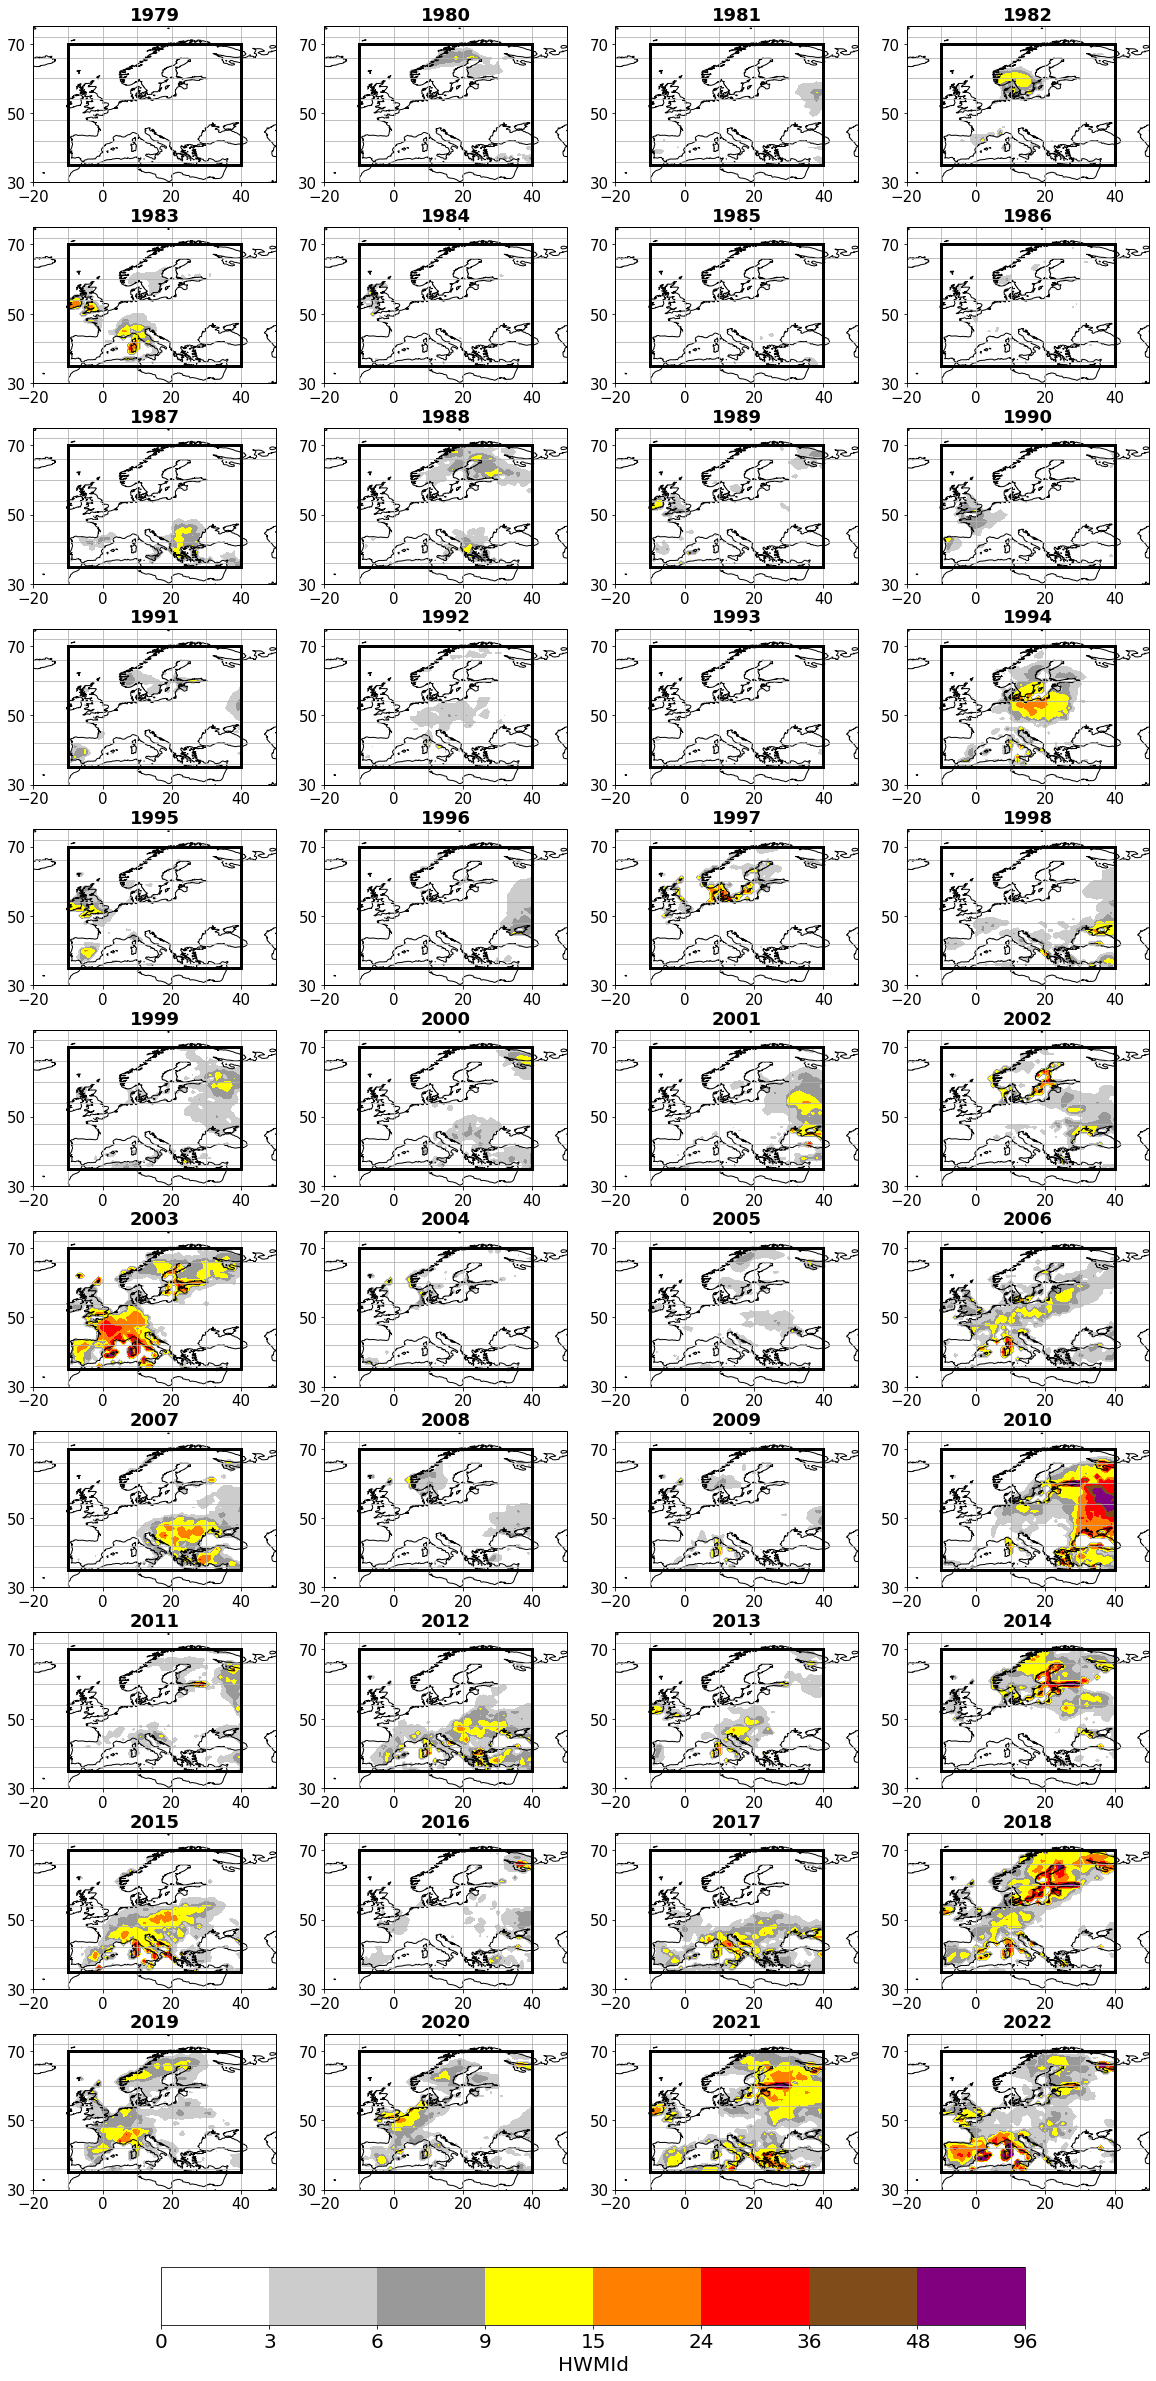

In [122]:
# Set general font size
plt.rcParams['font.size'] = '15'
# Define projection
prj = ccrs.PlateCarree()
fig = plt.figure(figsize=(20,40))
axs=[]
for i in range(1,45):
        axs.append(fig.add_subplot(11,4,i, projection=prj))
        
X_Europe, Y_Europe = (HWMID_lat_lon_xr.lon, HWMID_lat_lon_xr.lat)
levels= np.array([0,3,6,9,15,24,36,48,96])
years = [str(year) for year in range(1979, 2023)]

# Create non-linear level-spaced colormap, used in Russo et al. 2015
colors = [(1, 1, 1),             # white
          (0.8, 0.8, 0.8),       # light grey
          (0.6, 0.6, 0.6),       # dark grey
          (1, 1, 0),             # yellow
          (1, 0.5, 0),           # light red
          (1, 0, 0),             # red
          (0.5, 0.3, 0.1),       # brown
          (0.5, 0, 0.5)]         # purple
cmap = plt.cm.colors.ListedColormap(colors)
# Create a norm object using BoundaryNorm
norm = plt.cm.colors.BoundaryNorm(levels, cmap.N)

for j in range(0,44):
    contf= axs[j].contourf(X_Europe,Y_Europe, HWMID_lat_lon_xr.sel(year=slice(HWMID_lat_lon_xr.year[j],HWMID_lat_lon_xr.year[j])).squeeze(), cmap=cmap, levels=levels, transform=prj, norm=norm)
    axs[j].plot(x1, y1, x2, y2,x3,y3,x4,y4, color='black', linestyle='-', linewidth=3)
    axs[j].set_title(years[j], fontweight='bold')

for ax in axs:
    ax.coastlines('50m')
    #ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', fontsize =20, transform=ax.transAxes)
    #ax.text(0.5, -0.3, 'Longitude', va='bottom', ha='center', rotation='horizontal', rotation_mode='anchor', fontsize =20, transform=ax.transAxes)
    ax.gridlines()
    ax.set_extent([-20, 50, 30, 75], prj)
    ax.set_xticks([-20, 0,20, 40],crs=prj)
    ax.set_yticks([30, 50, 70],crs=prj)
    

cb_ax = fig.add_axes([0.214, 0.08, 0.6, 0.02])
cb = fig.colorbar(contf, cax=cb_ax, orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.set_label(label='HWMId', fontsize=20)
    
rasterize_list = [axs[s] for s in range(44)]
raster.rasterize_and_save('ERA5_Europe_HWMId_1979_2022.pdf', rasterize_list, dpi=300)